In [1]:
import PyMieScatt as ps
import numpy as np
import numpy.linalg as npl
import matplotlib.pyplot as plt
from matplotlib.contour import QuadContourSet
from PyMieScatt.Mie import Mie_ab
from matplotlib.collections import LineCollection
from scipy.ndimage import zoom
from scipy.integrate import trapz
from shapely import geometry
from mpl_toolkits import mplot3d

# Spectral solution of the inverse problem

### Choice of a wavelength (used for the entire method) in nm

In [65]:
wl = 500 

### Simulation of the measured intensity (LSP) for a given particle 

We use the function ScatteringFunction from PieMyScatt library that computes intensities according to the particle features and on the angle $\theta$ (that we choose between 10° and 65°). Given the intensity (we worked mostly with the left-polarized intensity), we can found some useful and typical spectral parameters: amplitude at zero-frequency ($A_0$) and the location of the peak after the zero-frequency ($L$). Those parameters will be used later to confirm our calculations and our method. In reality, those parameters (or intensity) are measured. 

#### Real particle features to find again

In [168]:
x_real = 15
m_real = 1.05

#### Graphs showing the measured intensities and its amplitude (using Fourier transform) and spectrum parameters calculation

In [169]:
def Characterization(x,m,wl,pol):
    M = 4096
    resolution = 0.2/(0.1*x)
    d = x*wl/np.pi
    theta, SL,SR,SU = ps.ScatteringFunction(m,wl,d,minAngle = 10, maxAngle = 65, angleMeasure = 'degrees',angularResolution = resolution)
    if pol == 'SL': 
        I = SL 
    elif pol == 'SR':
        I = SR 
    elif pol == 'SU':
        I = SU 
    N = len(theta)
    w = (np.sin(np.pi*(theta-theta[0])/(theta[-1]-theta[0])))**2
    window = w*I 
    P = []
    angle = []
    for k in range(N):
        s = 0
        q = k/(N*resolution)
        for j in range(N):
            s += window[j]*np.exp(-1j*2*np.pi*q*j/N)
           
        P.append((1/len(theta))**2*(np.conjugate(s)*s).real)
        angle.append(q)
    #Find the peak 
    #Pass the first peak 
    cond = False
    ind = 0 
    while not(cond) and ind+1<len(P):
        if P[ind]-P[ind+1]>0:
            ind+=1
        else: 
            cond = True 

    if ind+1 == len(P): 
        amp_peak = 0 
        angle_peak = 0 
        peak = [angle_peak,amp_peak]
    else: 
        amp_peak = max(P[ind:])
        angle_peak = np.where(P==amp_peak)[0]/(N*resolution)
        limit = np.where(P==amp_peak)[0]
        amp_min = min(P[ind:limit[0]])
        angle_min = np.where(P==amp_min)[0]/(N*resolution)
        minimum = [angle_min,amp_min]
        peak = [angle_peak,amp_peak]

    if peak[1] != 0:
        C = 1 - (amp_min/peak[1])
        #print('Weber contrast :',C)
    else:
        C = 0 
        #print('no contrast')
        
    return theta, I, window, angle, P, peak, C

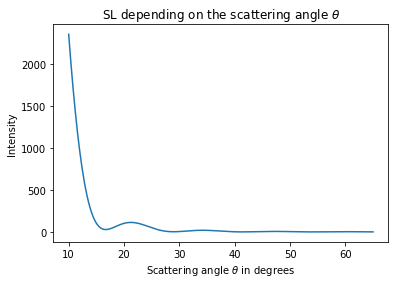

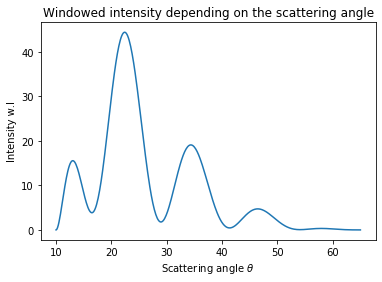

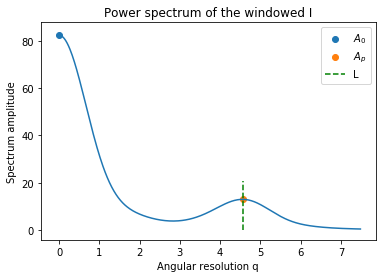

<function matplotlib.pyplot.show(*args, **kw)>

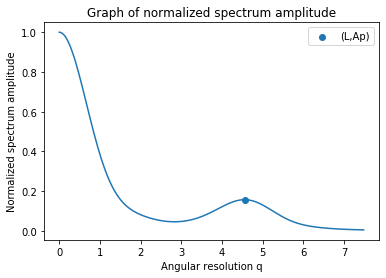

In [170]:
theta,I, window,angle,P,peak,C = Characterization(x_real,m_real,wl,'SL')
#print("Pour une taille :",x,", un indice de réfraction :",m,", une longueur d'onde :",wl)
plt.plot(theta,I)
plt.xlabel("Scattering angle $\\theta$ in degrees")
plt.ylabel("Intensity")
plt.title("SL depending on the scattering angle $\\theta$")
plt.show()

plt.plot(theta,window)
plt.xlabel("Scattering angle $\\theta$")
plt.ylabel("Intensity w.I")
plt.title("Windowed intensity depending on the scattering angle")
plt.show() 

plt.plot(angle,P)
plt.scatter(0,P[0],label ="$A_0$")
plt.scatter(peak[0],peak[1],label = "$A_p$")
plt.vlines(peak[0],0,max(P)/4,'g',linestyle = 'dashed',label = "L")
plt.xlabel("Angular resolution q")
plt.ylabel("Spectrum amplitude")
plt.title("Power spectrum of the windowed I")
plt.legend()
plt.show()

plt.plot(angle,P/P[0])
plt.scatter(peak[0],peak[1]/P[0],label = "(L,Ap)")
plt.xlabel("Angular resolution q")
plt.ylabel("Normalized spectrum amplitude")
plt.title("Graph of normalized spectrum amplitude")
plt.legend()
plt.show

### Study of the link between x,m,L and A0  

The second step of this method is the study the link (a linear form) between $x$ and $L$ and between $m$ and a combination of the spectral parameters. To find those links, we need to choose the right interval for the size $x$ and the refractive index $m$. First, we need to choose only real refractive index (this is a small approximation). 

#### Choice of the right interval for x: Weber contrast

The Weber contrast $C$ allow us to choose the right value for $x$. $$C = 1- \frac{A_{min}}{A_p}$$ where $A_{min}$ is the minimal amplitude between the peak at zero frequency and the location peak $L$ of amplitude $A_p$. If $C$ is equal to 0 (approximatly), it means that no peak or minimum can be found on the graphs. In this case, we pull out this value of $x$. Here, regarding the plot of the Weber contrast, we choose the take $x$ from 11 to 100. 

In [171]:
x1 = np.linspace(5,20,18)
m1 = np.linspace(1,1.5,18)
d1 = x1*wl/np.pi

C = np.zeros((len(x1),len(m1)))
for i in range(len(x1)):
    for j in range(len(m1)):
        C[i,j] = Characterization(x1[i],m1[j],wl,'SL')[-1]
        

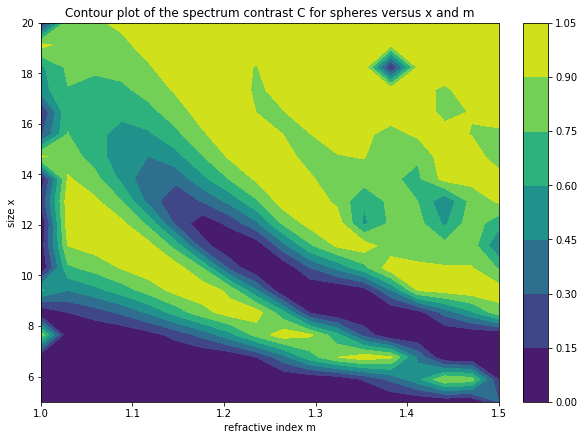

In [172]:
fig,ax = plt.subplots(figsize=(8,6),constrained_layout=True)
CS = ax.contourf(m1,x1,C)
cbar = fig.colorbar(CS)
ax.set_ylabel("size x")
ax.set_xlabel("refractive index m")
ax.set_title("Contour plot of the spectrum contrast C for spheres versus x and m")
plt.show()

#### Relation between x, m and the spectral parameters: 3D plots 

To find the links between our variables we did 3D plots of $L$ and $A_0$ in function of $x$ and $m$. And then we inverse the problem by plotting separatly $x$ and $m$ in function of $L$ and $A_0$. 

In [173]:
x = np.linspace(11,100,20)
m = np.linspace(1,1.5,20)
d = x*wl/np.pi

In [174]:
L = np.zeros((len(x),len(m)))
A0 = np.zeros((len(x),len(m)))
value_x = np.zeros((len(x),len(m))) 
value_m = np.zeros((len(x),len(m)))
C = np.zeros((len(x),len(m)))

for i in range(len(x)):
    for j in range(len(m)): 
        print(x[i],m[j])
        theta,I,window,angle,P,peak,C = Characterization(x[i],m[j],wl,'SL')
        L[i,j] = peak[0]
        A0[i,j] = P[0]
        value_x[i,j] = x[i]
        value_m[i,j] = m[j]
        

11.0 1.0
11.0 1.0263157894736843
11.0 1.0526315789473684
11.0 1.0789473684210527
11.0 1.1052631578947367
11.0 1.131578947368421
11.0 1.1578947368421053
11.0 1.1842105263157894
11.0 1.2105263157894737
11.0 1.236842105263158
11.0 1.263157894736842
11.0 1.2894736842105263
11.0 1.3157894736842106
11.0 1.3421052631578947
11.0 1.368421052631579
11.0 1.3947368421052633
11.0 1.4210526315789473
11.0 1.4473684210526314
11.0 1.4736842105263157
11.0 1.5
15.68421052631579 1.0
15.68421052631579 1.0263157894736843
15.68421052631579 1.0526315789473684
15.68421052631579 1.0789473684210527
15.68421052631579 1.1052631578947367
15.68421052631579 1.131578947368421
15.68421052631579 1.1578947368421053
15.68421052631579 1.1842105263157894
15.68421052631579 1.2105263157894737
15.68421052631579 1.236842105263158
15.68421052631579 1.263157894736842
15.68421052631579 1.2894736842105263
15.68421052631579 1.3157894736842106
15.68421052631579 1.3421052631578947
15.68421052631579 1.368421052631579
15.68421052631579 

62.526315789473685 1.4736842105263157
62.526315789473685 1.5
67.21052631578948 1.0
67.21052631578948 1.0263157894736843
67.21052631578948 1.0526315789473684
67.21052631578948 1.0789473684210527
67.21052631578948 1.1052631578947367
67.21052631578948 1.131578947368421
67.21052631578948 1.1578947368421053
67.21052631578948 1.1842105263157894
67.21052631578948 1.2105263157894737
67.21052631578948 1.236842105263158
67.21052631578948 1.263157894736842
67.21052631578948 1.2894736842105263
67.21052631578948 1.3157894736842106
67.21052631578948 1.3421052631578947
67.21052631578948 1.368421052631579
67.21052631578948 1.3947368421052633
67.21052631578948 1.4210526315789473
67.21052631578948 1.4473684210526314
67.21052631578948 1.4736842105263157
67.21052631578948 1.5
71.89473684210526 1.0
71.89473684210526 1.0263157894736843
71.89473684210526 1.0526315789473684
71.89473684210526 1.0789473684210527
71.89473684210526 1.1052631578947367
71.89473684210526 1.131578947368421
71.89473684210526 1.1578947

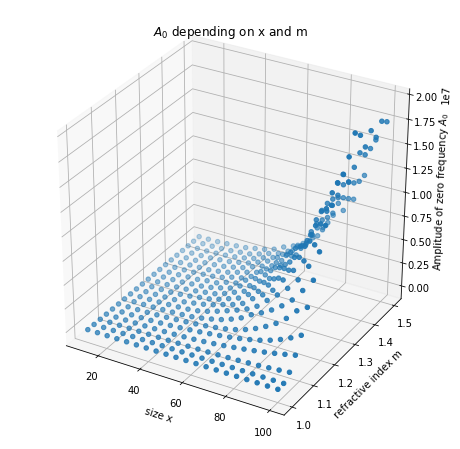

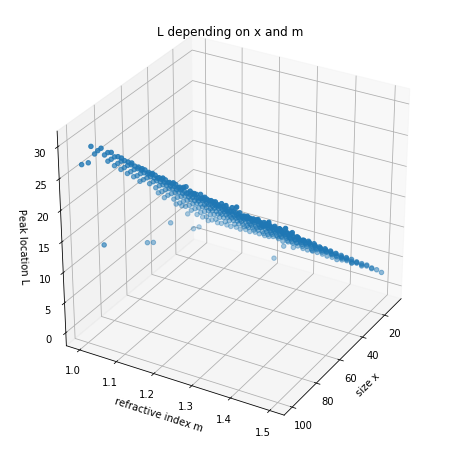

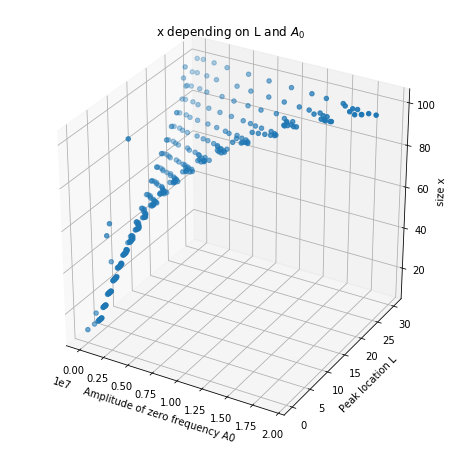

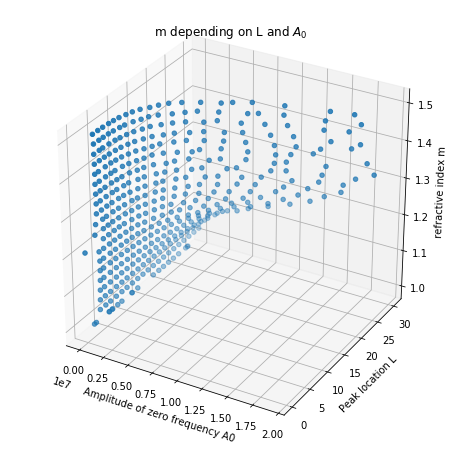

In [175]:
fig = plt.figure(figsize=(8,8))
ax = plt.gca(projection = '3d') 
ax.scatter(value_x,value_m,A0)
ax.set_xlabel("size x")
ax.set_ylabel("refractive index m")
ax.set_zlabel("Amplitude of zero frequency $A_0$")
ax.set_title("$A_0$ depending on x and m")
plt.show()

fig1 = plt.figure(figsize=(8,8))
ax1 = plt.gca(projection='3d')
ax1.scatter(value_x,value_m,L)
ax1.set_xlabel("size x")
ax1.set_ylabel("refractive index m")
ax1.set_zlabel("Peak location L")
ax1.set_title("L depending on x and m")
ax1.view_init(30,30)
plt.show()

fig2 = plt.figure(figsize=(8,8))
ax2 = plt.gca(projection = '3d')
ax2.scatter(A0,L,value_x)
ax2.set_ylabel("Peak location L")
ax2.set_xlabel("Amplitude of zero frequency A0")
ax2.set_zlabel("size x") 
ax2.set_title("x depending on L and $A_0$")
plt.show()

fig3 = plt.figure(figsize=(8,8))
ax3 = plt.gca(projection = '3d')
ax3.scatter(A0,L,value_m)
ax3.set_ylabel("Peak location L")
ax3.set_xlabel("Amplitude of zero frequency A0")
ax3.set_zlabel("refractive index m") 
ax3.set_title("m depending on L and $A_0$")
plt.show()

#### Uniqueness domains for  m

When we study the graph of $m$ in function of $A_0$ (for example) with a given $x$, we can see that the solution won't be unique for $m$ between 1 and 1.5 as set at the beginning. The first method to find the uniqueness domain is to choose the $m_{max}$ as the first local maximum of the graph. But this can be difficult to find in some applications. So we can use the signal-based uniqueness domain (corresponding to first the local minimum). In the following calculations, we will use the second method. 

In [176]:
diff = 10
for ind in range(len(x1)): 
    if abs(x_real-x[ind])<diff:
        _ind = ind
_x = x[_ind-1]
print(_x)

15.68421052631579


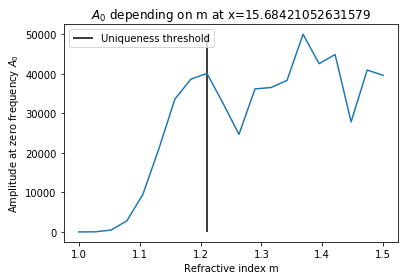

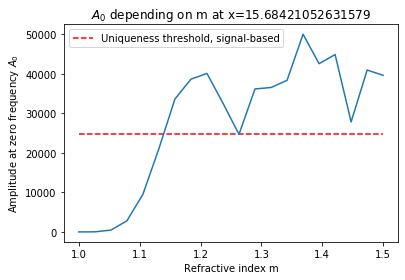

In [177]:
plt.plot(m,A0[_ind,:])
plt.title("$A_0$ depending on m at x="+str(_x))
plt.xlabel("Refractive index m")
plt.ylabel("Amplitude at zero frequency $A_0$")   


i = 1
cond = False
while i+1<len(A0[_ind,:]) and not(cond):
    if A0[_ind,i]>A0[_ind,i+1] and A0[_ind,i]>A0[_ind,i-1]:
        cond = True 
    i+=1

plt.vlines(m[i-1],0,max(A0[_ind,:]),label="Uniqueness threshold") 
plt.legend()
plt.show()

j = 1
cond1 = False
while j+1 < len(A0[_ind,:]) and not(cond1):
    if (A0[_ind,j]<A0[_ind,j+1]) and (A0[_ind,j]<A0[_ind,j-1]):
        cond1 = True
    j+=1


plt.plot(m,A0[_ind,:])
plt.title("$A_0$ depending on m at x="+str(_x))
plt.xlabel("Refractive index m")
plt.ylabel("Amplitude at zero frequency $A_0$")  
plt.hlines(A0[_ind,j-1],m[0],m[-1],'r','dashed',label="Uniqueness threshold, signal-based")
plt.legend()
plt.show()


#### Find linear coefficients between x,m (reduced),$A_0$ and L: 3D plots and calculation

In order to get the linear form between $m$ and the spectral parameters, we defined a linearized zero-frequency amplitude $B_0$ such that: $$B_0 = \frac{A_0^{1/4}}{L}$$
With the new domaine of $m$ and this new parameter, we plot similar graphs and we can see that the graph $x$ in function of $B_0$ and $L$ is a linear: $$x = \alpha L$$ where $\alpha$ is the coefficient we want to find. This is the same for $m$, $$m = 1+\beta B_0$$ where $\beta$ is the second coefficient we are looking for.

In [178]:
x = np.linspace(11,100,10)
m_r = np.linspace(1,1.13,10)
d = x*wl/np.pi

L_r = np.zeros((len(x),len(m_r)))
A0_r = np.zeros((len(x),len(m_r)))
value_x = np.zeros((len(x),len(m_r))) 
value_m_r = np.zeros((len(x),len(m_r)))

for i in range(len(x)):
    for j in range(len(m_r)): 
        print(x[i],m_r[j])
        theta,I,window,angle,P,peak,C = Characterization(x[i],m_r[j],wl,'SL')
        L_r[i,j] = peak[0]
        A0_r[i,j] = P[0]
        value_x[i,j] = x[i]
        value_m_r[i,j] = m_r[j]


11.0 1.0
11.0 1.0144444444444445
11.0 1.028888888888889
11.0 1.0433333333333332
11.0 1.0577777777777777
11.0 1.0722222222222222
11.0 1.0866666666666667
11.0 1.101111111111111
11.0 1.1155555555555554
11.0 1.13
20.88888888888889 1.0
20.88888888888889 1.0144444444444445
20.88888888888889 1.028888888888889
20.88888888888889 1.0433333333333332
20.88888888888889 1.0577777777777777
20.88888888888889 1.0722222222222222
20.88888888888889 1.0866666666666667
20.88888888888889 1.101111111111111
20.88888888888889 1.1155555555555554
20.88888888888889 1.13
30.77777777777778 1.0
30.77777777777778 1.0144444444444445
30.77777777777778 1.028888888888889
30.77777777777778 1.0433333333333332
30.77777777777778 1.0577777777777777
30.77777777777778 1.0722222222222222
30.77777777777778 1.0866666666666667
30.77777777777778 1.101111111111111
30.77777777777778 1.1155555555555554
30.77777777777778 1.13
40.66666666666667 1.0
40.66666666666667 1.0144444444444445
40.66666666666667 1.028888888888889
40.66666666666667 

In [179]:
B0 = np.sqrt(np.sqrt(A0_r))/L_r

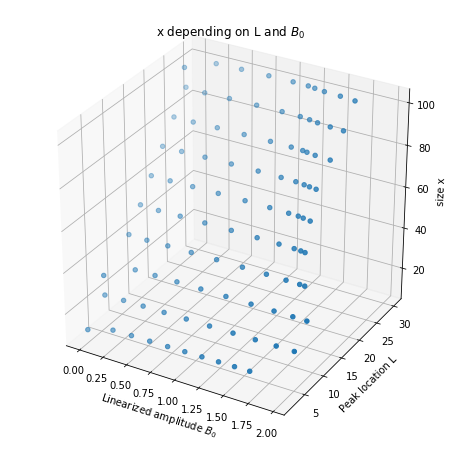

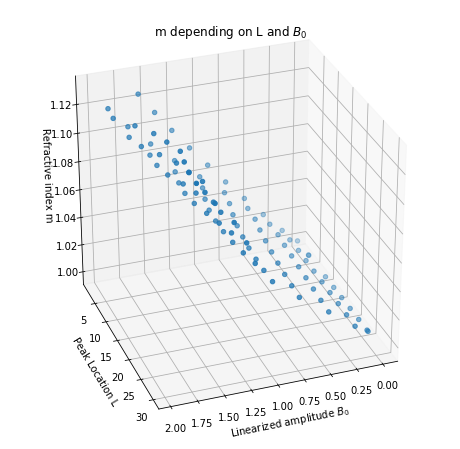

In [180]:
fig4 = plt.figure(figsize=(8,8))
ax4 = plt.gca(projection = '3d')
ax4.scatter(B0,L_r,value_x)
ax4.set_ylabel("Peak location L")
ax4.set_xlabel("Linearized amplitude $B_0$")
ax4.set_zlabel("size x") 
ax4.set_title("x depending on L and $B_0$")
plt.show()

fig5 = plt.figure(figsize=(8,8))
ax5 = plt.gca(projection='3d')
ax5.scatter(B0,L_r,value_m_r)
ax5.set_xlabel("Linearized amplitude $B_0$")
ax5.set_ylabel("Peak Location L")
ax5.set_zlabel("Refractive index m")
ax5.set_title("m depending on L and $B_0$")
ax5.view_init(30,70)
plt.show()

Now we use a graphic method to find both coefficients $\alpha$ and $\beta$. 

In [181]:
coef_x = 0 
for c in range(len(m_r)):
    coef_x += (x[0]-x[5])/(L_r[0,c]-L_r[5,c])
coef_x = coef_x/len(m_r)
print(coef_x)

3.3400222740811487


In [182]:
coef_m = 0 
for c in range(len(x)):
    coef_m += (m_r[0]-m_r[5])/(B0[c,0]-B0[c,5])
coef_m = coef_m/len(x)
print(coef_m)

0.06230057702979639


### Conclusion

By using the parameter $L$ and $A_0$ we found earlier for given particle features (that could be measured for a real experiment) and the linear relations we can encounter the particle features again. 

In [183]:
theta,I, window,angle,P,peak,C = Characterization(x_real,m_real,wl,'SL')

x_exp = coef*peak[0]
x_error = abs(x_exp-x_real)
print("The experimental size x:", x_exp)
print("The real size x:", x_real)
print("Error:",x_error)

m_exp = 1 + coef_m*(np.sqrt(np.sqrt(P[0]))/peak[0])
m_error = abs(m_exp-m_real)
print("The experimental refractive index:", m_exp)
print("The real refractive index:",m_real)
print("Error:",m_error)

[15.22419354]
[1.04118479]
